In [1]:
import numpy as np
import networkx as nx
import time
import torch
import torch.nn.functional as F
import torch.nn as nn
import ot
import scipy.spatial.distance as distance
import matplotlib.pyplot as plt

def generate_random_dists(num_dists, n):
    dists = np.random.random_sample((num_dists, n))
    norms = np.linalg.norm(dists, ord=1, axis = 1)
    dists = dists/norms[:, None]
    return dists

def generate_random_points(n, dim=2, low=-10, high=10):
    return (high - low) * np.random.rand(n, dim) + low

def generate_distance_metric(points):
    D = np.zeros((len(points), len(points)))
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            dist = distance.euclidean(points[i], points[j])
            D[i][j] = dist
            D[j][i] = dist
    return D

def format_distance_matrix(D):
    p_index = 0
    param_list = []
    for i in range(D.shape[0]):
        for j in range(D.shape[0]):
            param_list.append(D[i][j])
            D[i][j] = p_index
            
            p_index += 1
    return nn.Parameter(torch.tensor(param_list))


In [2]:
# Input: a distance matrix M which references indices in a list of parameters,
def mst_transform(M, output_M, params, output_params):
    root = None
    parents = {}
    subtrees = {}
    node_id = {}
    id_num = 1
    tree = nx.Graph()
    tree.add_nodes_from(np.arange(M.shape[0]))
    
    connected_component_per_vert = {}
    cc_cur_edge = {}
    leaves = []
    for i in range(M.shape[0]):
        node_id[i] = id_num
        leaves.append(id_num)
        connected_component_per_vert[i] = i
        cc_cur_edge[i] = (None, np.inf)
        id_num += 1
    iteration = 0
    p_index = 0
    while not nx.is_connected(tree):
        for i in range(M.shape[0]):
            for j in range(i+1, M.shape[0]):
                edge = (i, j)
                l_index = M[i][j]
                length = params[l_index]
                c1 = connected_component_per_vert[i] #(e1, e2)
                c2 = connected_component_per_vert[j] #(e3, e4)
                if c1 != c2:
                    if length < cc_cur_edge[c1][1]:
                        cc_cur_edge[c1] = (edge, length)
                    if length < cc_cur_edge[c2][1]:
                        cc_cur_edge[c2] = (edge, length)
        new_cc_cur_edge = {}

        for hrn in cc_cur_edge:
            new_root_node = cc_cur_edge[hrn][0]
            height = cc_cur_edge[hrn][1]
            if not tree.has_node(new_root_node) and new_root_node != None:
                with torch.no_grad():
                    output_params[p_index] = height
                root = new_root_node
                tree.add_node(new_root_node, h=height)
                # Gives index of the node
                node_id[new_root_node] = id_num
                new_cc_cur_edge[new_root_node] = (None, np.inf)
                
                # left and right subtrees. 
                verts0 = []
                verts1 = []
                
                left_subtree = nx.node_connected_component(tree, connected_component_per_vert[new_root_node[0]])
                
                right_subtree = nx.node_connected_component(tree, connected_component_per_vert[new_root_node[1]])
                
                tree.add_edge(connected_component_per_vert[new_root_node[0]], new_root_node)
                tree.add_edge(connected_component_per_vert[new_root_node[1]], new_root_node)
                for v in left_subtree:
                    if v not in parents:
                        parents[v] = new_root_node
                    if type(v) is not tuple:
                        connected_component_per_vert[v] = new_root_node
                        verts0.append(v)
                for v in right_subtree:
                    if v not in parents:
                        parents[v] = new_root_node
                    if type(v) is not tuple:
                        connected_component_per_vert[v] = new_root_node
                        output_M[v, verts0] = p_index
                        verts1.append(v)
                
                subtrees[new_root_node] = [verts0, verts1]
                for i in verts0:
                    output_M[i, verts1] = p_index
                id_num += 1
                p_index += 1
        cc_cur_edge = new_cc_cur_edge
        iteration += 1
        
    node_id[root] = 0
    for i in range(M.shape[0]):
        #tree.nodes[i]['h'] = torch.min(M[i])
        output_M[i][i] = p_index
        with torch.no_grad():
            output_params[p_index] = 0.0
        p_index += 1
    
    p = [0]*tree.number_of_nodes()
    for node in parents:
        parent = parents[node]
        p[node_id[node]] = node_id[parent]
    p[0] = -1
    return tree, parents, p, leaves, root

# D = np.array([[0.0, 1.0, 20.0, 5.0], [1.0, 0.0, 10.0, 30.0], [30.0, 10.0, 0.0, 1.0], [5.0, 30.0, 1.0, 0.0]])
# #parameters = nn.Parameter(torch.zeros(D.shape[0]*D.shape[0], dtype=torch.float))
# parameters = format_distance_matrix(D)
# print(parameters)
# D = D.astype(int)
# tree, parents, p, leaves, root, UM = new_mst_transform(D, parameters)
# optimizer = torch.optim.Adam([parameters], lr=0.01)
# print(UM)
# print(parameters[UM[[0, 1],[2, 3]]])
# print(parameters)
# loss = torch.sum(parameters[UM[[0, 1],[2, 3]]] * torch.tensor([0.5, 0.5]))
# loss.backward()
# optimizer.step()
# print(parameters)

In [3]:
import pydot
from networkx.drawing.nx_pydot import *
from tqdm import trange
import time
import tree_estimators as te

def format_distributions( dist):
    formatted_dist = []
    for i in range(len(dist)):
        if dist[i] > 0:
            formatted_dist.append((i, dist[i]))
    return formatted_dist

def tree_wasserstein(UM, parameters, solver, mu, rho):
    solver.tree_query(mu, rho)
    matching = solver.return_matching()
    masses = solver.return_mass()
    return torch.sum(torch.tensor(masses) * parameters[UM[matching[0], matching[1]]])
#     result = 0.0
#     for m in matching:
#         v1 = m[0][0]
#         v2 = m[0][1]
#         mass = m[1]
#         if v1 < v2:
#             result += UM[v1][v2] * mass
#         else:
#             result += UM[v2][v1] * mass
#     return result

# for pair in matching:
#     get all pairs that match with it
#     

def loss_fn(UM, parameters, solver, D, dists1, dists2):
    loss = 0
    for i in range(len(dists1)):
        for j in range(len(dists2)):
            mu = dists1[i]
            rho = dists2[j]
            mu_f = format_distributions(mu)
            rho_f = format_distributions(rho)
            loss += (ot.emd2(mu, rho, D) - tree_wasserstein(UM, parameters, solver, mu_f, rho_f))**2
    return (loss)**(0.5)

def convert_to_distance_mat(M):
    for i in range(M.shape[0]):
        for j in range(i + 1, M.shape[0]):
            M[i][j] = (2 * M[i][j] - M[i][i] - M[j][j]) * 0.5
    
    
# Careful when setting parameters for torch gradient descent
def train_wasserstein(D, dists1, dists2, max_iterations=5):
    fig, axs = plt.subplots(1, figsize=(10, 10))
    
    # Initialize training process
    #M = torch.tensor(D, dtype=torch.float)
    M1 = D.copy()
    M2 = D.copy()
    parameters1 = format_distance_matrix(M1)
    
    parameters2 = format_distance_matrix(M2)
    #parameters = nn.Parameter(torch.zeros(M.shape[0], M.shape[0], dtype=torch.float))
    optimizer = torch.optim.Adam([parameters1, parameters2], lr=0.01)
    M1 = M1.astype(int)
    M2 = M2.astype(int)
    # initial tree 
    
    tree, parents, p, leaves, root = mst_transform(M1, M2, parameters1, parameters2)
    solver = te.TreeEstimators()
    solver.load_tree(p, leaves)
    print("Root 1:", root)
    
    losses = []
    for i in trange(max_iterations):
        optimizer.zero_grad()
        solver.load_tree(p, leaves)
        if i % 2 == 0:
            loss = loss_fn(M2, parameters2, solver, D, dists1, dists2)
        else: 
            loss = loss_fn(M1, parameters1, solver, D, dists1, dists2)
         
        losses.append(loss.detach())
        loss.backward()
        optimizer.step()
        
        #M = parameters.clone().detach()
        if i % 2 == 0:
            tree, parents, p, leaves, root = mst_transform(M2, M1, parameters2, parameters1)
        else:
            tree, parents, p, leaves, root = mst_transform(M1, M2, parameters1, parameters2)
#         if len(losses) >= 5:
#             if losses[-2] < losses[-1]:
#                 print("LOSS IS INCREASING")
#                 h()
        
    print("beginning loss:", losses[0])
    print("ending loss:", losses[max_iterations-1])
    print("Root end:", root)
    

    #nx.draw(tree, with_labels="True", ax=axs[1])
    axs.plot(np.arange(0, len(losses)), losses)
    return tree, parents, p, leaves, root, M2, parameters2



## Comparing average error of QT and learned UM on synthetic dataset (\R^2)

In [ ]:
import ot_estimators as ote



np.random.seed(1)
n_points = 20
pointset = generate_random_points(n_points, dim=10, low=-20, high=20)
pointset = pointset.astype(np.float32)
#print(pointset)
D = generate_distance_metric(pointset)
d1_train = generate_random_dists(50, n_points)
d2_train = generate_random_dists(50, n_points)

d1_test = generate_random_dists(20, n_points)
d2_test = generate_random_dists(20, n_points)


## train tree structure
tree, parents, p, leaves, root, M, parameters=train_wasserstein(D, d1_train, d1_train, max_iterations=2000)






  0%|          | 0/2000 [00:00<?, ?it/s]

Root 1: (10, 15)


 58%|█████▊    | 1160/2000 [17:41<13:19,  1.05it/s]

In [28]:
errors_tw = []
tree_solver = te.TreeEstimators()
tree_solver.load_tree(p, leaves)
w1s = np.zeros((len(d1_test), len(d2_test)))
params = parameters.detach().numpy()
for i in range(len(d1_test)):
    for j in range(len(d2_test)):
        d1 = format_distributions(d1_test[i])
        d2 = format_distributions(d2_test[i])
        tw = tree_wasserstein(M, params, tree_solver, d1, d2)
        w1_distance = ot.emd2(d1_test[i], d2_test[i], D)
        w1s[i][j] = w1_distance
        errors_tw.append(abs(tw - w1_distance))

tw_avg_error = np.mean(errors_tw)
tw_std_dev = np.std(errors_tw)
print("Average TW error:", tw_avg_error)
print("TW std dev:", tw_std_dev)

Average TW error: 6.8588281852189406
TW std dev: 2.648632719548725


In [32]:
solver = ote.OTEstimators()
solver.load_vocabulary(pointset)
print("SUCCESSFULLY LOADED QT")
errors_qt = []
errors_ft = []
for i in range(len(d1_test)):
    for j in range(len(d2_test)):
        d1 = format_distributions(d1_test[i])
        d2 = format_distributions(d2_test[i])
        qt_distance = solver.quadtree_distance(d1, d2)
        ft_distance = solver.flowtree_query(d1, d2)
        errors_qt.append(abs(qt_distance - w1s[i][j]))
        errors_ft.append(abs(ft_distance - w1s[i][j]))
        
qt_avg_error = np.mean(errors_qt)
qt_std_dev = np.std(errors_qt)
ft_avg_error = np.mean(errors_ft)
ft_std_dev = np.std(errors_ft)
print("Average QT error:", qt_avg_error)
print("QT std dev.", qt_std_dev)
print("Average FT error:", ft_avg_error)
print("FT std dev.", ft_std_dev)

SUCCESSFULLY LOADED QT
Average QT error: 45.92641966170151
QT std dev. 16.72160935672479
Average FT error: 4.459966920078588
FT std dev. 1.6422621836046831


### Nearest Neighbor

In [33]:
import pandas as pd
queries = generate_random_dists(100, n_points)
candidates = generate_random_dists(100, n_points)

#np.save("syntheticR2_parents1", p)
#np.save("syntheticR2_leaves1", leaves)
distances = {'q':[], 'c':[], 'w1':[], 'qt':[], 'ft':[], 'tw':[]}
for i in trange(len(queries)):
    for j in range(len(candidates)):
        distances['q'].append(i)
        distances['c'].append(j)
        d1 = format_distributions(queries[i])
        d2 = format_distributions(candidates[j])
        distances['w1'].append(ot.emd2(queries[i], candidates[j], D))
        distances['qt'].append(solver.quadtree_distance(d1, d2))
        distances['ft'].append(solver.flowtree_query(d1, d2))
        distances['tw'].append(tree_wasserstein(M, params, tree_solver, d1, d2).item())
        
df = pd.DataFrame.from_dict(distances)

100%|██████████| 100/100 [00:03<00:00, 29.39it/s]


In [34]:
tw = [0]*100
qt = [0]*100
ft = [0]*100
for i in trange(len(queries)):
    query_d = df['q'] == i
    filtered_data = df[query_d]
    id_true = filtered_data['c'][filtered_data['w1'].idxmin()]
    for m in range(1, 101):
        top_m_ft = filtered_data.nsmallest(m, 'ft')
        top_m_qt = filtered_data.nsmallest(m, 'qt')
        top_m_tw = filtered_data.nsmallest(m, 'tw')
        if id_true in list(top_m_ft['c']):
            ft[m - 1] += 1
        if id_true in list(top_m_qt['c']):
            qt[m - 1] += 1
        if id_true in list(top_m_tw['c']):
            tw[m - 1] += 1
        

100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


In [22]:
print("Average wasserstein distance:", np.mean(df['w1']))
print("Average optimzed tree wasserstein distance", np.mean(df['tw']))

Average wasserstein distance: 9.954929649931303
Average optimzed tree wasserstein distance 9.181318900657596


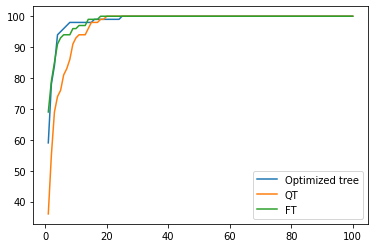

In [35]:
plt.clf()
plt.plot(np.arange(1, 101), tw, label="Optimized tree")
plt.plot(np.arange(1, 101), qt, label="QT")
plt.plot(np.arange(1, 101), ft, label="FT")
plt.legend()


## Comparing Nearest Neighbor

In [117]:
# Input: a matrix M
# Return: networkx tree and ultramatrix, UM
def matrix_to_um(M, param_matrix):
    root = None
    parents = {}
    subtrees = {}
    node_id = {}
    id_num = 1
    tree = nx.Graph()
    tree.add_nodes_from(np.arange(M.shape[0]))
    
    connected_component_per_vert = {}
    cc_cur_edge = {}
    leaves = []
    for i in range(M.shape[0]):
        node_id[i] = id_num
        leaves.append(id_num)
        connected_component_per_vert[i] = i
        cc_cur_edge[i] = (None, np.inf)
        id_num += 1
    iteration = 0
    while not nx.is_connected(tree):
        for i in range(M.shape[0]):
            for j in range(i+1, M.shape[0]):
                edge = (i, j)
                length = M[i][j]
                c1 = connected_component_per_vert[i] #(e1, e2)
                c2 = connected_component_per_vert[j] #(e3, e4)
                if c1 != c2:
                    if length < cc_cur_edge[c1][1]:
                        cc_cur_edge[c1] = (edge, length)
                    if length < cc_cur_edge[c2][1]:
                        cc_cur_edge[c2] = (edge, length)
        new_cc_cur_edge = {}

        for hrn in cc_cur_edge:
            new_root_node = cc_cur_edge[hrn][0]
            height = cc_cur_edge[hrn][1]
            
            if not tree.has_node(new_root_node) and new_root_node != None:
                root = new_root_node
                tree.add_node(new_root_node, h=height)
                # Gives index of the node
                node_id[new_root_node] = id_num
                new_cc_cur_edge[new_root_node] = (None, np.inf)
                verts0 = []
                verts1 = []
                left_subtree = nx.node_connected_component(tree, connected_component_per_vert[new_root_node[0]])
                
                right_subtree = nx.node_connected_component(tree, connected_component_per_vert[new_root_node[1]])
                
                tree.add_edge(connected_component_per_vert[new_root_node[0]], new_root_node)
                tree.add_edge(connected_component_per_vert[new_root_node[1]], new_root_node)
                for v in left_subtree:
                    if v not in parents:
                        parents[v] = new_root_node
                    if type(v) is not tuple:
                        connected_component_per_vert[v] = new_root_node
                        verts0.append(v)
                for v in right_subtree:
                    if v not in parents:
                        parents[v] = new_root_node
                    if type(v) is not tuple:
                        connected_component_per_vert[v] = new_root_node
                        with torch.no_grad():
                            param_matrix[v, verts0] = height
                        verts1.append(v)
                
                subtrees[new_root_node] = [verts0, verts1]
                for i in verts0:
                    with torch.no_grad():
                        param_matrix[i, verts1] = height
                id_num += 1

        cc_cur_edge = new_cc_cur_edge
        iteration += 1
    node_id[root] = 0
    for i in range(M.shape[0]):
        tree.nodes[i]['h'] = torch.min(M[i])
        with torch.no_grad():
            param_matrix[i][i] = 0
    p = [0]*tree.number_of_nodes()
    # may be able to incorporate in the tree building process
    for node in parents:
        parent = parents[node]
        p[node_id[node]] = node_id[parent]
    p[0] = -1
#     print(p)
#     print(leaves)
    return tree, parents, p, leaves, root
        
        

  0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: Ended matching process early

In [ ]:
def tw2(M, parents, root, dist1, dist2):
    max_iterations = 1000
    next_level = []
    excess = {}
    
    result = 0
    mu = np.copy(dist1)
    rho = np.copy(dist2)
    num_nodes = len(parents.keys()) + 1
    still_matching = True
    for i in range(M.shape[0]):
        # push mass associated to next level along with node id
        new_mu = max(mu[i] - rho[i], 0)
        new_rho = max(rho[i] - mu[i], 0)
        mu[i] = new_mu
        rho[i] = new_rho
        parent_node = parents[i]
        if mu[i] > 0 or rho[i] > 0:
            if parent_node not in excess:
                excess[parent_node] = {'mu': [], 'rho': []}
                if mu[i] > 0:
                    excess[parent_node]['mu'].append(i)
                elif rho[i] > 0:
                    excess[parent_node]['rho'].append(i)
            else:
                if mu[i] > 0:
                    excess[parent_node]['mu'].append(i)
                elif rho[i] > 0:
                    excess[parent_node]['rho'].append(i)
                    
    iterations = 0
    
    while still_matching:
        new_excess = {}
        marker = {}
        for node in excess:
            if node != root:
                parent = parents[node]
                # Mark parents of the nodes which currently have excess flow
                marker[parent] = True
        for node in excess:
            if node != root:
                parent = parents[node]
                # If the current node is a parent of a node which has excess flow, keep it in the excess flow
                if (node in marker) and (not excess[node]['mu'] or not excess[node]['rho']):
                    if node not in new_excess:
                        new_excess[node] = excess[node]
                    else:
                        new_excess[node]['mu'] = new_excess[node]['mu'] + excess[node]['mu']
                        new_excess[node]['rho'] = new_excess[node]['rho'] + excess[node]['rho']
                # Else if the node has only one type of mass, push it to its parent. 
                elif not excess[node]['mu'] or not excess[node]['rho']:
                    if parent not in new_excess:
                        new_excess[parent] = {'mu':[], 'rho': []}
                        new_excess[parent]['mu'] = excess[node]['mu']
                        new_excess[parent]['rho'] = excess[node]['rho']
                    else:
                        new_excess[parent]['mu'] = new_excess[parent]['mu'] + excess[node]['mu']
                        new_excess[parent]['rho'] = new_excess[parent]['rho'] + excess[node]['rho']
                
                while excess[node]['mu'] and excess[node]['rho']:
                    m1 = excess[node]['mu'][-1]
                    m2 = excess[node]['rho'][-1]
                    if m1 < m2:
                        dist = M[m1][m2]
                    else:
                        dist = M[m2][m1]
                    print("TW Matching:", m1, m2, "MASS:", min(mu[m1], rho[m2]))
                    result += min(mu[m1], rho[m2]) * dist

                    mu_excess = max(mu[m1] - rho[m2], 0)
                    rho_excess = max(rho[m2] - mu[m1], 0)

                    mu[m1] = mu_excess
                    rho[m2] = rho_excess

                    if mu[m1] > 0 or rho[m2] > 0:
                        if parent not in new_excess:
                            new_excess[parent] = {'mu': [], 'rho': []}
                            if mu[m1] > 0:
                                new_excess[parent]['mu'].append(m1)
                            elif rho[m2] > 0:
                                new_excess[parent]['rho'].append(m2)
                        else:
                            if mu[m1] > 0:
                                new_excess[parent]['mu'].append(m1)
                            elif rho[m2] > 0:
                                new_excess[parent]['rho'].append(m2)
                    if mu[m1] == 0:
                        del excess[node]['mu'][-1]
                    if mu[m2] == 0:
                        del excess[node]['rho'][-1]
            else:
                if node not in new_excess:
                    new_excess[node] = excess[node]
                else:
                    new_excess[node]['mu'] = new_excess[node]['mu'] + excess[node]['mu']
                    new_excess[node]['rho'] = new_excess[node]['rho'] + excess[node]['rho']
        excess = new_excess
        if len(excess) == 1 or iterations > num_nodes:
            still_matching = False
            if iterations > num_nodes:
                raise RuntimeError('ERROR IN MATCHING!!!!')
        iterations += 1
    
    # Match everything at root level
    while excess[root]['mu'] and excess[root]['rho']:
        m1 = excess[root]['mu'][0]
        m2 = excess[root]['rho'][0]
        if m1 < m2:
            dist = M[m1][m2]
        else:
            dist = M[m2][m1]
        print("TW Matching:", m1, m2, "MASS:", min(mu[m1], rho[m2]))
        result += min(mu[m1], rho[m2]) * dist
        mu_excess = max(mu[m1] - rho[m2], 0)
        rho_excess = max(rho[m2] - mu[m1], 0)
        mu[m1] = mu_excess
        rho[m2] = rho_excess
        if mu[m1] == 0:
            del excess[root]['mu'][0]
        if mu[m2] == 0:
            del excess[root]['rho'][0]
    return result


